In [1]:
%config InlineBackend.figure_format = "svg"

import sys
sys.path.append("../")

from src.rl_algorithms.pomdp_lookahead import build_tree, pomdp_lookahead
from src.networks.ddn import DynamicDecisionNetwork as DDN
from src.networks.nodes import DiscreteNode
from src.trees.tree import Tree
from tqdm import tqdm

# Creating a dynamic decision network

## Example: Tiger problem

### Constructing the Dynamic Decision Network

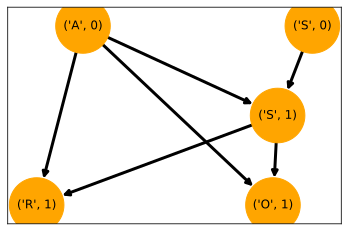

In [2]:
# Create nodes
s0 = DiscreteNode(("S", 0), node_type=DDN.state_type, value_space=[0, 1])
a0 = DiscreteNode(("A", 0), node_type=DDN.action_type, value_space=[0, 1, 2])
s1 = DiscreteNode(("S", 1), node_type=DDN.state_type, value_space=[0, 1])
o1 = DiscreteNode(("O", 1), node_type=DDN.observation_type, value_space=[0, 1])
r1 = DiscreteNode(("R", 1), node_type=DDN.reward_type, value_space=[-100, -1, 10])

# Discount factor of the POMDP
discount = 0.8

# Create the DDN structure
ddn = DDN(discount=discount)
ddn.add_nodes([s0, s1, o1, r1, a0])
ddn.add_edges([
    (("S", 0), ("S", 1)), 
    (("A", 0), ("S", 1)), 
    (("A", 0), ("R", 1)), 
    (("A", 0), ("O", 1)), 
    (("S", 1), ("O", 1)), 
    (("S", 1), ("R", 1)) 
])
ddn.draw()

### Adding CPT data to the DDN

In [3]:
# Add data for node State 0
data = {
    ("S", 0): [0,1], 
    "Prob": [0.5,0.5]
}
ddn.add_pt(("S", 0), data)

# Add data for node State 1
data = {
    ("S", 0): [0,0,0,0,0,0,1,1,1,1,1,1], 
    ("A", 0): [0,0,1,1,2,2,0,0,1,1,2,2], 
    ("S", 1): [0,1,0,1,0,1,0,1,0,1,0,1], 
    "Prob": [1,0,0.5,0.5,0.5,0.5,0,1,0.5,0.5,0.5,0.5]
}
ddn.add_pt(("S", 1), data)

# Add data for node Evidence
data = {
    ("A", 0): [0,0,0,0,1,1,1,1,2,2,2,2], 
    ("S", 1): [0,0,1,1,0,0,1,1,0,0,1,1], 
    ("O", 1): [0,1,0,1,0,1,0,1,0,1,0,1], 
    "Prob": [0.85,0.15,0.15,0.85,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5]
}
ddn.add_pt(("O", 1), data)

# Add data for node Reward
data = {
    ("A", 0): [0,0,0,0,0,0,1,1,1,1,1,1,2,2,2,2,2,2], 
    ("S", 1): [0,0,0,1,1,1,0,0,0,1,1,1,0,0,0,1,1,1], 
    ("R", 1): [-100,-1,10,-100,-1,10,-100,-1,10,-100,-1,10,-100,-1,10,-100,-1,10], 
    "Prob": [0,1,0,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0]
}
ddn.add_pt(("R", 1), data)

# Initialize ddn
ddn.initialize()

### Robot search problem

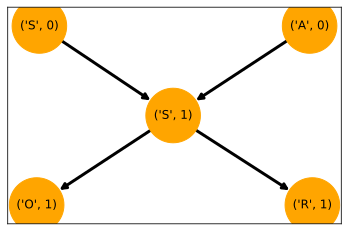

In [23]:
# Create nodes
s0 = DiscreteNode(("S", 0), node_type=DDN.state_type, value_space=[0,1,2,3])
a0 = DiscreteNode(("A", 0), node_type=DDN.action_type, value_space=[0,1])
s1 = DiscreteNode(("S", 1), node_type=DDN.state_type, value_space=[0,1,2,3])
o1 = DiscreteNode(("O", 1), node_type=DDN.observation_type, value_space=[0,1])
r1 = DiscreteNode(("R", 1), node_type=DDN.reward_type, value_space=[0,1])

# Discount factor of the POMDP
discount = 0.4

# Create the DDN structure
robot_ddn = DDN(discount=discount)
robot_ddn.add_nodes([s0, s1, o1, r1, a0])
robot_ddn.add_edges([
    (("S", 0), ("S", 1)), 
    (("A", 0), ("S", 1)),
    (("S", 1), ("O", 1)), 
    (("S", 1), ("R", 1)) 
])
robot_ddn.draw()

In [24]:
# Add data for node State 0
data = {
    ("S", 0): [0,1,2,3], 
    "Prob": [0.25,0.25,0.25,0.25]
}
robot_ddn.add_pt(("S", 0), data)

# Add data for node State 1
data = {
    ("S", 0): [0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3], 
    ("A", 0): [0,0,0,0,1,1,1,1,0,0,0,0,1,1,1,1,0,0,0,0,1,1,1,1,0,0,0,0,1,1,1,1], 
    ("S", 1): [0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3], 
    "Prob": [1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1/3,1/3,0,1/3,1/3,1/3,0,1/3,0,0,1,0,0,0,0,1]
}
robot_ddn.add_pt(("S", 1), data)

# Add data for node Evidence
data = { 
    ("S", 1): [0,0,1,1,2,2,3,3], 
    ("O", 1): [0,1,0,1,0,1,0,1], 
    "Prob": [1,0,1,0,0,1,1,0]
}
robot_ddn.add_pt(("O", 1), data)

# Add data for node Reward
data = { 
    ("S", 1): [0,0,1,1,2,2,3,3], 
    ("R", 1): [0,1,0,1,0,1,0,1], 
    "Prob": [1,0,1,0,0,1,1,0]
}
robot_ddn.add_pt(("R", 1), data)

# Initialize ddn
robot_ddn.initialize()

### Calculating best action

In [25]:
# Build the lookahead tree
horizon = 2
action_space = robot_ddn.get_space(robot_ddn.action_type)
observation_space = robot_ddn.get_space(robot_ddn.observation_type)
tree = build_tree({}, action_space, observation_space, horizon)

In [15]:
n_samples = 100
pomdp_lookahead(robot_ddn, tree, n_samples)

{('A', 0): 1}

In [26]:
# Calculate best action for ten time-steps
r = []
for _ in tqdm(range(3)):
    actions = pomdp_lookahead(robot_ddn, tree, n_samples)
    observations = robot_ddn.sample_observation(actions)
    robot_ddn.belief_update(actions, observations, n_samples)
    # ddn.increase_time()
    r.append(actions)

100%|██████████| 3/3 [00:15<00:00,  5.31s/it]


In [27]:
r

[{('A', 0): 1}, {('A', 0): 1}, {('A', 0): 0}]

In [ ]:
# Should the best action be always the same???